In [1]:
from scipy.io import loadmat
import numpy as np
import math
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
epsilon = 1e-20

In [2]:
data = loadmat('data.mat')
datatest = loadmat('datatest.mat')
dataKunknown = loadmat('dataKunknown.mat')

In [3]:
data = np.array(data['X'])
datatest_Sk = np.array(datatest['Sk'])
datatest_mu = np.array(datatest['mu'])
datatest_pi = np.array(datatest['pi'])
datatest = np.array(datatest['X'])
dataKunknown = np.array(dataKunknown['X'])

In [4]:
def get_num_clusters(data, max_clusters=15, show=True):
    """
    data: NxD Matrix (N samples of D-dimensional data)
    """
    assert max_clusters <= data.shape[0]
    
    loss = []
    for k in range(1, max_clusters+1):
        km = KMeans(n_clusters=k).fit(data)
        loss.append(km.inertia_)
    
    C = 1
    m_init = loss[0]-loss[1]
    for k in range(2, max_clusters+1):
        m = loss[k-1]-loss[k]
        if m < 0.1*m_init:
            break
        
        C += 1
        m_prev = m
    
    if show:
        plt.plot(range(1, max_clusters+1), loss, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Sum of Squared Distances')
        plt.title('Loss vs Number of Clusters')
        plt.show()
    
    return C

In [5]:
def compute_LL(data, mu, sigma, pi, C):
    N = data.shape[0]
    r = np.zeros((N, C))
    for i in range(C):
        r[:,i] = multivariate_normal.pdf(data, mean=mu[i,:], cov=sigma[i,:,:]) + epsilon
        r[:,i] = pi[i] * r[:,i]

    L_i = np.sum(r,1).reshape(-1,1)
    LL_i = np.log(L_i)
    
    return np.sum(LL_i)

In [7]:
def EM(data, C, C_known=True, tol=1e-10, max_iter=100, num_init=10, plot_LL=False):
    """
    data: NxD Matrix (N D-Dimensional drawings)
    C: number of clusters if C known, else it is maximum possible number of clusters
    """
    if not C_known:
        C = get_num_clusters(data=data, max_clusters=C, show=True)
        print('Predicted Number of Clusters:', C)
        
    N = data.shape[0] # number of drawings
    D = data.shape[1] # dimension of each drawing
    best_loss = -float("inf")
    best_pi = None
    best_mu = None
    best_sigma = None

    for init in range(num_init):  # try with different initializations
        try:  # can get nans but we don't want termination on exception
            # Initialization (pi: equiprobable, mu: random, sigma: I)
            pi = 1/float(C)*np.ones(C)
            mu = np.random.randn(C,D)
            sigma = np.zeros((C,D,D))
            sigma[...] = np.identity(D)
            prev_loss = None
            
            LL = []
            for it in range(max_iter):
                
                # E-step
                r = np.zeros((N, C))
                for i in range(C):
                    r[:,i] = multivariate_normal.pdf(data, mean=mu[i,:], cov=sigma[i,:,:]) + epsilon
                    r[:,i] = pi[i] * r[:,i]
                    
                r = r/np.sum(r,1).reshape(-1,1)
                
                # M-step
                pi_prev = pi
                mu_prev = mu
                sigma_prev = sigma
                
                pi = np.sum(r, axis=0) / (1.0 * N)
                
                mu = np.zeros((C, D))
                sigma = np.zeros((C, D, D))
                for i in range(C):      
                    mu[i,:] = np.sum(data * r[:,i][:,np.newaxis], axis=0) / (pi[i]*N)
                    X_i = data - mu[i, :][np.newaxis, :]
                    sigma[i,:,:] = np.dot((X_i * r[:,i][:,np.newaxis]).T , X_i) / (pi[i]*N)
                    
                # Compute log-likelihood (should be non-decreasing over iterations)
                LL.append(compute_LL(data, mu, sigma, pi, C))
                
                # 'Loss' computation to check for convergence
                loss = np.linalg.norm(pi-pi_prev) + np.linalg.norm(mu-mu_prev) + np.linalg.norm(sigma-sigma_prev)
                
                if not math.isnan(loss) and loss > best_loss:
                    best_loss = loss
                    best_mu = mu
                    best_pi = pi
                    best_sigma = sigma
                
                if prev_loss is not None:
                    diff = np.abs(loss - prev_loss)
                    if diff < tol:
                        print('Initialization/ Iteration: ', init+1, '/', it+1)
                        break
                
                prev_loss = loss
            
            if plot_LL:
                plt.plot(LL, 'rx-')
                plt.xlabel('Iteration')
                plt.ylabel('Log-Likelihood')
                plt.title('Log-Likelihood vs Number of Iterations')
                plt.show()

        except:
            pass

    return best_loss, best_pi, best_mu, best_sigma

### EM with known number of clusters
Log-likelihood plots shown only below, but can always get them by setting plot_LL=True. Algorithm is rerun for num_init number of initializations and best estimates returned. "Initialization/ Iteration: x/ y" refer to initialization number and number of iterations after which convergence occured/ termination took place. Convergence did not take place in max_iter number of iterations where this is not quoted.

Initialization/ Iteration:  1 / 59


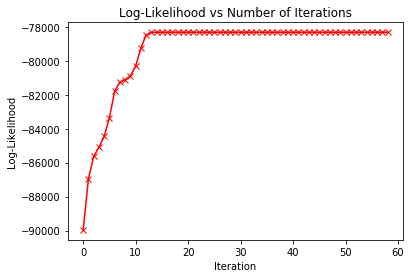

Initialization/ Iteration:  2 / 404


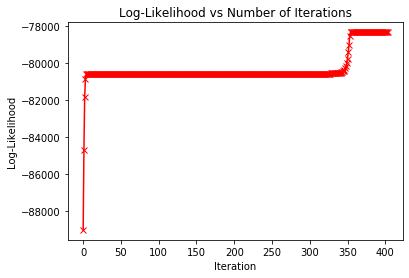

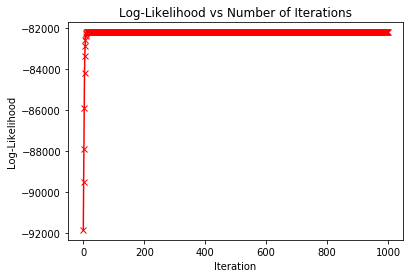

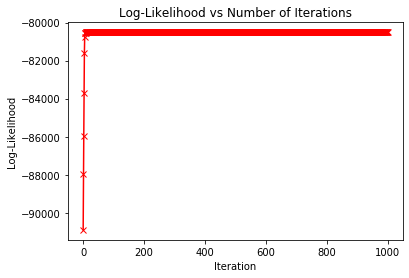

Initialization/ Iteration:  5 / 60


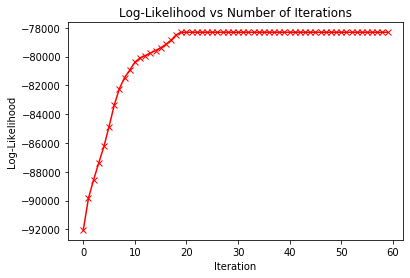

In [8]:
loss, pi_hat, mu_hat, sigma_hat = EM(data.T, 6, C_known=True, num_init=5, max_iter=1000, tol=1e-13, plot_LL=True)

In [9]:
print('pi_hat:\n', pi_hat)
print('pi:\n', datatest_pi)
print('-------------------------------------------------------')
print('mu_hat:\n', mu_hat)
print('mu:\n', datatest_mu)
print('-------------------------------------------------------')
print('sigma_hat:\n', sigma_hat)
print('sigma:\n', datatest_Sk)

pi_hat:
 [0.33469047 0.01058397 0.33839414 0.20694692 0.02174239 0.0876421 ]
pi:
 [[0.01043281 0.26895835 0.28062474 0.2366198  0.06744033 0.13592397]]
-------------------------------------------------------
mu_hat:
 [[-2.06364895 -3.33929996  0.87405724  1.15505462  2.12252918]
 [ 0.01087813 -1.18710006  1.26039425 -0.57856576  3.61883908]
 [-2.95380305 -0.45937148  2.35858607  0.05403362 -0.19571488]
 [ 0.22747546  1.69832352  2.13327454 -1.83220986  1.52670736]
 [-3.37961786  1.2807679  -0.44774957  1.29210646 -0.59354171]
 [-1.08464799 -0.78821846  0.83485731 -1.28401468  1.16171391]]
mu:
 [[ 1.87804763  2.01460276  5.64851401  3.15466113  6.42986499]
 [-5.57177316  3.61996699  3.08595679  3.4657632   4.70275826]
 [-0.09702777 -3.06449789  3.96279726 -2.59418763  5.12072787]
 [-3.09801301  7.14814256  1.70830536  1.07696299 -4.85182442]
 [ 0.65486176  3.86150204 -1.24478056  3.29094618 -1.42021293]
 [-0.89504701  0.64401815 -6.38468565  5.16454199  5.04971146]]
--------------------

EM implementation on data with **known** number of clusters but still asking algorithm to find number of clusters itself. Doing this to (1) validate goodness of get_num_clusters(), (2) use greater number of initializations (without producing log-likelihood plots each time), hoping for better results.

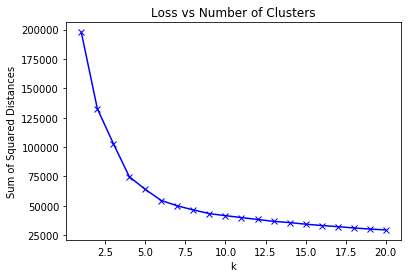

Predicted Number of Clusters: 6
Initialization/ Iteration:  1 / 95
Initialization/ Iteration:  2 / 61
Initialization/ Iteration:  3 / 64
Initialization/ Iteration:  4 / 60
Initialization/ Iteration:  6 / 75
Initialization/ Iteration:  7 / 65
Initialization/ Iteration:  8 / 57
Initialization/ Iteration:  9 / 59
Initialization/ Iteration:  11 / 434
Initialization/ Iteration:  12 / 245
Initialization/ Iteration:  13 / 63
Initialization/ Iteration:  14 / 187
Initialization/ Iteration:  15 / 63
Initialization/ Iteration:  17 / 486
Initialization/ Iteration:  19 / 82
Initialization/ Iteration:  20 / 63
Initialization/ Iteration:  21 / 117
Initialization/ Iteration:  24 / 997
Initialization/ Iteration:  25 / 179
Initialization/ Iteration:  27 / 63
Initialization/ Iteration:  28 / 74
Initialization/ Iteration:  30 / 553
Initialization/ Iteration:  31 / 58
Initialization/ Iteration:  32 / 62
Initialization/ Iteration:  33 / 69
Initialization/ Iteration:  34 / 57
Initialization/ Iteration:  36 /

In [10]:
loss, pi_hat, mu_hat, sigma_hat = EM(data.T, 20, C_known=False, num_init=100, max_iter=1000, tol=1e-13)

In [11]:
print('pi_hat:\n', pi_hat)
print('pi:\n', datatest_pi)
print('-------------------------------------------------------')
print('mu_hat:\n', mu_hat)
print('mu:\n', datatest_mu)
print('-------------------------------------------------------')
print('sigma_hat:\n', sigma_hat)
print('sigma:\n', datatest_Sk)

pi_hat:
 [0.01030223 0.18138377 0.13094014 0.24924123 0.02466256 0.40347008]
pi:
 [[0.01043281 0.26895835 0.28062474 0.2366198  0.06744033 0.13592397]]
-------------------------------------------------------
mu_hat:
 [[ 0.21777212 -1.79932105  1.26097652  0.1116868   0.36287397]
 [-2.41330559 -0.56961087  2.25815974  1.46692127  0.35344626]
 [-0.31128417 -0.77083279  1.06220165  0.08514374  1.53336447]
 [-1.05082624 -0.94529444  0.18034682 -1.25827728  1.91851566]
 [ 0.97555824 -0.74785819  2.33629529  0.25592617  1.48095028]
 [-2.72011409 -1.23572356  2.34138878 -0.0890669   0.75345518]]
mu:
 [[ 1.87804763  2.01460276  5.64851401  3.15466113  6.42986499]
 [-5.57177316  3.61996699  3.08595679  3.4657632   4.70275826]
 [-0.09702777 -3.06449789  3.96279726 -2.59418763  5.12072787]
 [-3.09801301  7.14814256  1.70830536  1.07696299 -4.85182442]
 [ 0.65486176  3.86150204 -1.24478056  3.29094618 -1.42021293]
 [-0.89504701  0.64401815 -6.38468565  5.16454199  5.04971146]]
--------------------

### EM with Unknown number of clusters

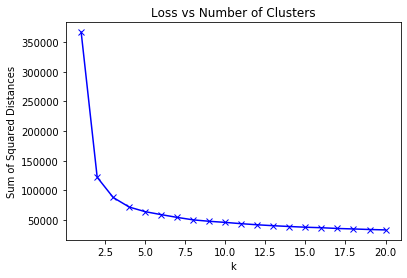

Predicted Number of Clusters: 3
Initialization/ Iteration:  1 / 34
Initialization/ Iteration:  2 / 34
Initialization/ Iteration:  3 / 43
Initialization/ Iteration:  4 / 34
Initialization/ Iteration:  5 / 31
Initialization/ Iteration:  6 / 32
Initialization/ Iteration:  7 / 38
Initialization/ Iteration:  8 / 35
Initialization/ Iteration:  9 / 41
Initialization/ Iteration:  10 / 35
Initialization/ Iteration:  11 / 33
Initialization/ Iteration:  12 / 31
Initialization/ Iteration:  13 / 34
Initialization/ Iteration:  14 / 33
Initialization/ Iteration:  15 / 52
Initialization/ Iteration:  16 / 33
Initialization/ Iteration:  17 / 37
Initialization/ Iteration:  18 / 32
Initialization/ Iteration:  19 / 40
Initialization/ Iteration:  20 / 36
Initialization/ Iteration:  21 / 40
Initialization/ Iteration:  22 / 32
Initialization/ Iteration:  23 / 32
Initialization/ Iteration:  24 / 33
Initialization/ Iteration:  25 / 34
Initialization/ Iteration:  26 / 35
Initialization/ Iteration:  27 / 32
Initi

In [12]:
loss, pi_hat, mu_hat, sigma_hat = EM(dataKunknown.T, 20, C_known=False, num_init=100, max_iter=1000, tol=1e-13)

In [13]:
print('pi_hat:\n', pi_hat)
print('mu_hat:\n', mu_hat)
print('sigma_hat:\n', sigma_hat)

pi_hat:
 [0.04176429 0.63770214 0.32053357]
mu_hat:
 [[ 0.0040738   0.34965512 -0.01300788  1.43204486  0.38153994]
 [ 3.47404054 -0.18864614 -0.61699132  0.80367481  3.83830545]
 [-3.75775583  0.05710178 -1.88445652  0.40683246 -0.82067041]]
sigma_hat:
 [[[31.69597787 -4.54288423  0.71154352  0.04750877 23.15585583]
  [-4.54288423  2.55625897 -1.22450892 -1.6419292  -3.92944702]
  [ 0.71154352 -1.22450892  2.863129    2.37653047  0.22964602]
  [ 0.04750877 -1.6419292   2.37653047  4.30398877 -0.65880355]
  [23.15585583 -3.92944702  0.22964602 -0.65880355 18.45155412]]

 [[ 7.4356087  -0.63772121  1.13530838  1.01781027  3.15579323]
  [-0.63772121  2.00608304 -0.66695394 -1.27196026 -0.42108338]
  [ 1.13530838 -0.66695394  2.25330753  1.39518957  0.33619208]
  [ 1.01781027 -1.27196026  1.39518957  3.26474017 -0.36626208]
  [ 3.15579323 -0.42108338  0.33619208 -0.36626208  2.72047244]]

 [[ 9.15819073 -0.41348605  1.6459592  -1.06412375  5.08598732]
  [-0.41348605  0.91086173 -0.2272914

### Discussion/ Analysis

**(a) The method used to initialize your parameters before the iterations begin.**

Pi was initialized to be equiprobable for each cluster i.e. every pi_k was set to be 1/K. Sigma was initialized to be identity matrix of relevant shape for each cluster. Mu was initialized randomly for each cluster by getting vector of appropriate size from standard normal distribution.

Initialization is critical for EM since convergence to *local* optima is guaranteed only. To get better estimates, I did not restrict algorithm to one initialization but reran it multiple (num_init) times, returning only the best estimates as the final estimates. This would always provide at least as good an estimate as the algorithm run with initialization done only once.

**(b) The method used to end iterations.**

The iterations were terminated when estimates appeared to have converged or a particular number (max_iter) of iterations were completed. To check for convergence, I computed sum of frobenius norms of difference between current and previous estimates of mu, sigma and pi, and 'declared' convergence when this was below a certain threshold/ tolerance level (tol). Simply put, when estimate of theta (mu, sigma, pi combined) was not changing much. The threshold (tol) was set at 1e-13 after a bit of trial and error; neither wanted to keep it too high that convergence is said to have been achieved even before good estimates start appearing nor wanted to keep it too low that convergence is (almost) never achieved within max_iter iterations.

Also tried methods like terminating when log-likelihood does not increase (at all or more than a certain threshold) but this did not provide any significant advantage over the method explained in last paragraph. Log-likelihood can in fact increase by quite a lot after not changing over multiple iterations, as seen in second plot of log-likelihood provided earlier. There are other methods like dealing with variational lower bound but did not try to code them.

**(c) The method used to estimate the number of clusters for the data in DataKunknown.mat. Clearly explain the logic behind your choice.**

I devised an automated version of the common "Elbow Method". First, I chose the maximum number of clusters (max_clusters) expected; that I can choose this number is a reasonable assumption when I do have some problem context, and this cannot be more than the number of data points of course (keeping it fixed to maximum possible number can be extremely, and unnecessarily, computationally demanding). Second, I applied KMeans algorithm (from sklearn) for each number of cluster (k) from 1 to max_clusters, and stored sum of squared differences between relevant cluster head (mu_k) and data point for each k. Using this, I was able to obtain loss vs number of clusters plot like ones shown earlier. Third, I estimated the number of clusters to be the number where "elbow" or bend in the plot was seen. Intuition behind this is that gains in increasing number of clusters become much lower after the elbow so we are probably crossing the actual number and merely overfitting/ overestimating afterwards. For the elbow detection, I implemented that elbow is at C (number of clusters) when the 'gradient' first becomes less than 0.1 of the original gradient; since x-axis (number of clusters) is increasing 1-unit at a time, this means that C = k when difference between loss with k and k-1 clusters became ten times less than initial 'gradient' (difference between loss with 2 clusters and 1 cluster).